## First linear predictive coding model

This notebook is going to throw together some different terminology coming from 'keras', 'tensorflow', and more generic predictive coding jargon. The idea is the creation of a linear predictive coding model that is easy to specify and easy to extend. The sequential specification method of 'keras' is ideally suited for this specification. For this purpose, a mixture of questions and goals is important:

- The first implementation will be given by 'Hierarchical()' (inspired by 'Sequential()').
- Should 'Hierarchical()' be merely inspired by or actually implemented on top of 'Sequential()'?
- It seems natural to start off by formulating the input, i. e. the lowest layer, and proceed from there. After specifying the lowest layer, one might thus specify the transformation upon this lowest layer (though this specification will be a feature that will be added later), and then add the next higher layer.
- 'predicode' should thus definitely use the layers from 'keras'.
- The output is likely going to have to include a copy of the estimation and true state of every layer.

This process is necessarily going to include some exploration before settling on a sensible procedure.

### Create Hierarchical akin to Sequential

As a first pass, the following code must work:
```{python}
import predicode as pc
hpc = pc.Hierarchical()
hpc.add(keras.Activation('relu'))
hpc.add(keras.Dense(4))
```

In [4]:
import predicode as pc
import keras
hpc = pc.Hierarchical()
hpc.add(keras.layers.Activation('relu', input_shape = (10,)))
hpc.add(keras.layers.Dense(4))

Using TensorFlow backend.
W0823 01:10:10.263563 140503168038720 deprecation_wrapper.py:119] From /home/sflippl/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 01:10:10.289473 140503168038720 deprecation_wrapper.py:119] From /home/sflippl/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 01:10:10.295683 140503168038720 deprecation_wrapper.py:119] From /home/sflippl/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [5]:
hpc.add(keras.layers.Activation('relu'))

In [5]:
art = pc.DecayingMultiNormal(10, 100)

### First fit using tensorflow directly

#### Understanding Tensorflow

We now fit a tensorflow predictive coding model with 10 input dimensions and 4 latent dimensions. We first use an example to understand a bit better how Tensorflow works -- we simply predict the output given a certain input and compute the mean squared error.

In [6]:
import tensorflow as tf
import numpy as np

In [7]:
input = tf.constant(art.data)

In [8]:
latent_array = np.array([np.array([1.,1.,1.,1.])]*100)

In [9]:
latent = tf.constant(latent_array)

In [10]:
import sklearn.decomposition as decomp
art_pca = decomp.PCA(n_components = 4).fit(art.data)

In [11]:
weights = tf.constant(art_pca.components_)

In [12]:
prediction = tf.matmul(latent, weights)

In [53]:
error = tf.losses.mean_squared_error(input, prediction)

W0821 01:52:23.502819 140692113475392 deprecation.py:323] From /home/sflippl/.local/lib/python3.7/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [54]:
writer = tf.summary.FileWriter('.')
writer.add_graph(tf.get_default_graph())
writer.flush()

In [58]:
sess = tf.Session()
print(sess.run(error))

0.54916465


#### Understanding estimators

We now fit an estimator that generates the best latent variables, following the 'Creating Custom Estimators' tutorial on tensorflow.org.

In [13]:
train_x = {str(i): art.data[:,i] for i in range(art.data.shape[1])}

In [14]:
observed_columns = [tf.feature_column.numeric_column(key=key) for key in train_x.keys()]

The goal is to have the following code work:

For this purpose, we must define a custom 'state_estimator'. Since we are currently inferring the latent states, the weights are fixed. The weights thus represent tensors, whereas the weights represent operations. Accordingly, we essentially flip the computational graph.

In [15]:
dct_weights = {"theta1_%d-%d"%(i,j): np.array([art_pca.components_[i,j]]) for i in range(weights.shape[0]) for j in range(weights.shape[1])}

In [16]:
dct_weights

{'theta1_0-0': array([-0.37593458]),
 'theta1_0-1': array([0.44660314]),
 'theta1_0-2': array([-0.06655914]),
 'theta1_0-3': array([-0.0658276]),
 'theta1_0-4': array([0.66387109]),
 'theta1_0-5': array([-0.1667903]),
 'theta1_0-6': array([0.08629256]),
 'theta1_0-7': array([-0.03118381]),
 'theta1_0-8': array([0.24703254]),
 'theta1_0-9': array([0.33536204]),
 'theta1_1-0': array([-0.12240433]),
 'theta1_1-1': array([-0.02433083]),
 'theta1_1-2': array([0.29516051]),
 'theta1_1-3': array([-0.59586923]),
 'theta1_1-4': array([0.01317754]),
 'theta1_1-5': array([0.36974514]),
 'theta1_1-6': array([-0.10461511]),
 'theta1_1-7': array([0.37006281]),
 'theta1_1-8': array([-0.38021622]),
 'theta1_1-9': array([0.33601344]),
 'theta1_2-0': array([0.23962836]),
 'theta1_2-1': array([0.0004807]),
 'theta1_2-2': array([0.2678398]),
 'theta1_2-3': array([0.57348647]),
 'theta1_2-4': array([0.21299678]),
 'theta1_2-5': array([0.38186292]),
 'theta1_2-6': array([0.35854457]),
 'theta1_2-7': array([

In [17]:
latent_weights = [tf.feature_column.numeric_column(key = key, dtype = tf.float64) for key in dct_weights.keys()]

In [18]:
latent_weights

[NumericColumn(key='theta1_0-0', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='theta1_0-1', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='theta1_0-2', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='theta1_0-3', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='theta1_0-4', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='theta1_0-5', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='theta1_0-6', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='theta1_0-7', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='theta1_0-8', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='theta1_0-9', shape=(1,), default_value=None,

In [19]:
def state_estimator(features, labels, mode, params):
    flipped_graph = tf.feature_column.input_layer(features, params['latent_weights'])
    flipped_graph = tf.layers.dense(flipped_graph, units = 10*100)
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'prediction': flipped_graph
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    loss = tf.losses.mean_squared_error(flipped_graph, labels)
    
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode, loss=loss)
    
    assert mode == tf.estimator.ModeKeys.TRAIN

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=1)
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

In [20]:
hpc = tf.estimator.Estimator(
    model_fn=state_estimator,
    params={
        'latent_weights': latent_weights,
        'units': 4
    })

W0823 01:10:32.298853 140503168038720 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpo6wwm3c7


In [21]:
art.data.shape

(100, 10)

In [22]:
hpc.train(input_fn = lambda: (dct_weights, art_data.flatten()), steps = 10000)

W0823 01:10:32.666815 140503168038720 deprecation.py:323] From /home/sflippl/.local/lib/python3.7/site-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


NameError: name 'art_data' is not defined

In [ ]:
evaluation = hpc.evaluate(input_fn = lambda:(dct_weights, np.array([art.data.flatten()])), steps = 1)

In [23]:
evaluation

NameError: name 'evaluation' is not defined

In [24]:
prediction = hpc.predict(input_fn = lambda:(dct_weights, np.array([art.data.flatten()])))

In [25]:
predicted = next(prediction)

W0823 01:10:33.321393 140503168038720 estimator.py:1000] Input graph does not use tf.data.Dataset or contain a QueueRunner. That means predict yields forever. This is probably a mistake.
W0823 01:10:33.325584 140503168038720 deprecation.py:323] From /home/sflippl/.local/lib/python3.7/site-packages/tensorflow/python/feature_column/feature_column.py:205: NumericColumn._get_dense_tensor (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0823 01:10:33.326913 140503168038720 deprecation.py:323] From /home/sflippl/.local/lib/python3.7/site-packages/tensorflow/python/feature_column/feature_column.py:2115: NumericColumn._transform_feature (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are be

In [26]:
art_pca

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [27]:
actual_prediction = np.matmul(art.data, np.matmul(art_pca.components_.T, art_pca.components_))

In [28]:
pred = np.array(predicted['prediction'])
pred.shape = (100,10)

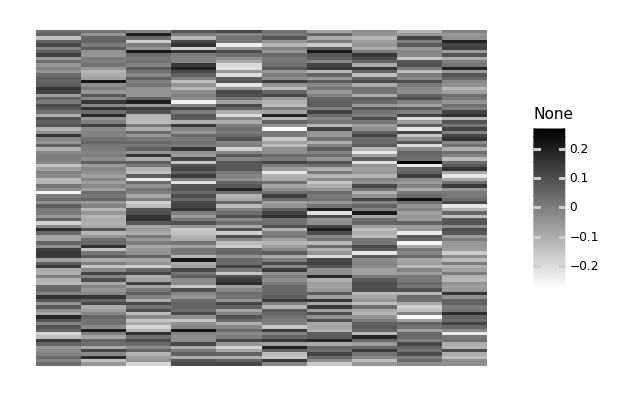

<ggplot: (8781365092202)>

In [29]:
import lazytools
lazytools.matrix_heatmap(pred)

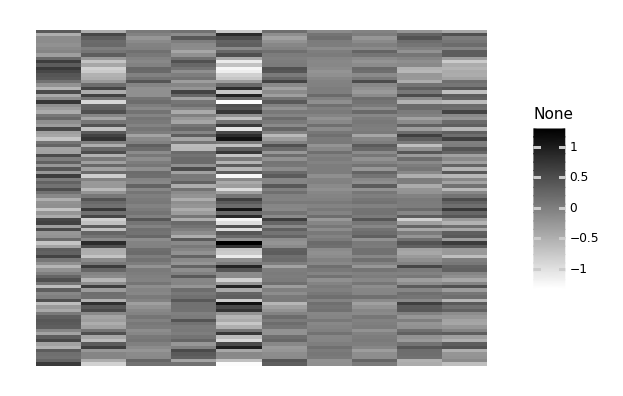

<ggplot: (8781362938558)>

In [30]:
lazytools.matrix_heatmap(actual_prediction)

Both are thus similar to each other, but differently scaled for some reason. This might have something to do with involuntary scaling. This is likely an issue of the PCA implementation and not really of concern. More as a more global concern, I will not that Tensorflow currently uses CPUs instead of GPUs, a problem I will solve once we have extracted the actual latent variables.

In [31]:
hpc.get_variable_names()

ValueError: Could not find trained model in model_dir: /tmp/tmpo6wwm3c7.

In [ ]:
hpc.get_variable_value('dense/kernel')[:,1]

The lesson from this (or alternatively drawing a quick diagram): We still have samples. What used to be samples turns into dimensions, but what used to be dimensions turns into samples, which means, the columns of theta are samples and its rows are dimensions.

#### Estimator of the latent variables

In [32]:
art.data.shape

(100, 10)

In [33]:
observed_dct = {str(i): art.data[i,:] for i in range(art.data.shape[0])}

In [34]:
observed_columns = [tf.feature_column.numeric_column(key=key) for key in observed_dct.keys()]

In [35]:
dct_weights = {"theta1_%d"%(i): art_pca.components_[i,:] for i in range(weights.shape[0])}

In [36]:
latent_weights = [tf.feature_column.numeric_column(key = key, dtype = tf.float64) for key in dct_weights.keys()]

In [37]:
def state_estimator(features, labels, mode, params):
    flipped_graph = tf.feature_column.input_layer(features, params['latent_weights'])
    flipped_graph = tf.layers.dense(flipped_graph, units = 100, use_bias = False)
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'prediction': flipped_graph
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    loss = tf.losses.mean_squared_error(flipped_graph, labels)
    
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode, loss=loss)
    
    assert mode == tf.estimator.ModeKeys.TRAIN

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=1)
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

In [38]:
help(tf.layers.dense)

Help on function dense in module tensorflow.python.layers.core:

dense(inputs, units, activation=None, use_bias=True, kernel_initializer=None, bias_initializer=<tensorflow.python.ops.init_ops.Zeros object at 0x7fc93183f8d0>, kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, trainable=True, name=None, reuse=None)
    Functional interface for the densely-connected layer. (deprecated)
    
    Instructions for updating:
    Use keras.layers.dense instead.
    
    This layer implements the operation:
    `outputs = activation(inputs * kernel + bias)`
    where `activation` is the activation function passed as the `activation`
    argument (if not `None`), `kernel` is a weights matrix created by the layer,
    and `bias` is a bias vector created by the layer
    (only if `use_bias` is `True`).
    
    Arguments:
      inputs: Tensor input.
      units: Integer or Long, dimensionality of the output space.
      activati

In [39]:
hpc = tf.estimator.Estimator(
    model_fn=state_estimator,
    params={
        'latent_weights': latent_weights,
        'units': 4
    })

W0823 01:10:36.630481 140503168038720 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpo2zj2e2_


In [40]:
hpc.train(input_fn = lambda: (dct_weights, art.data.T), steps = 10000)

W0823 01:10:37.362521 140503168038720 basic_session_run_hooks.py:724] It seems that global step (tf.train.get_global_step) has not been increased. Current value (could be stable): 107 vs previous value: 107. You could increase the global step by passing tf.train.get_global_step() to Optimizer.apply_gradients or Optimizer.minimize.
W0823 01:10:37.364422 140503168038720 basic_session_run_hooks.py:724] It seems that global step (tf.train.get_global_step) has not been increased. Current value (could be stable): 109 vs previous value: 109. You could increase the global step by passing tf.train.get_global_step() to Optimizer.apply_gradients or Optimizer.minimize.
W0823 01:10:37.366378 140503168038720 basic_session_run_hooks.py:724] It seems that global step (tf.train.get_global_step) has not been increased. Current value (could be stable): 111 vs previous value: 111. You could increase the global step by passing tf.train.get_global_step() to Optimizer.apply_gradients or Optimizer.minimize.
W

In [41]:
evaluation = hpc.evaluate(input_fn = lambda:(dct_weights, art.data.T), steps = 1)

W0823 01:10:40.979073 140503168038720 deprecation.py:323] From /home/sflippl/.local/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [42]:
evaluation

{'loss': 4.2674452e-05, 'global_step': 10000}

In [43]:
prediction = hpc.predict(input_fn = lambda:(dct_weights, art.data.T))

In [44]:
predicted_lst = [next(prediction)['prediction'] for i in range(10)]

W0823 01:10:41.113993 140503168038720 estimator.py:1000] Input graph does not use tf.data.Dataset or contain a QueueRunner. That means predict yields forever. This is probably a mistake.


In [45]:
predicted = np.array(predicted_lst).T

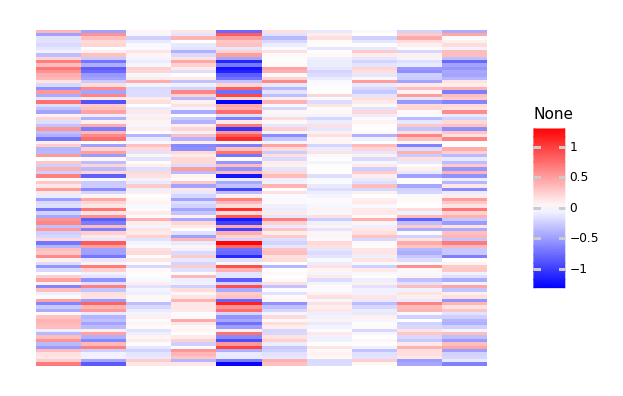

<ggplot: (-9223363255511115709)>

In [46]:
lazytools.matrix_heatmap(predicted, pole = 0)

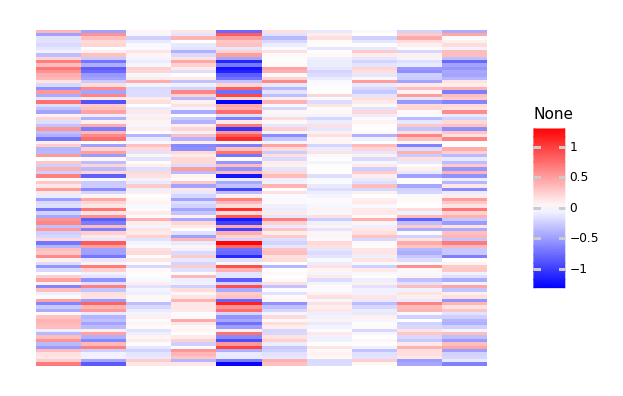

<ggplot: (-9223363255511131406)>

In [47]:
lazytools.matrix_heatmap(actual_prediction, pole = 0)

In [48]:
latent_values = hpc.get_variable_value('dense/kernel').T

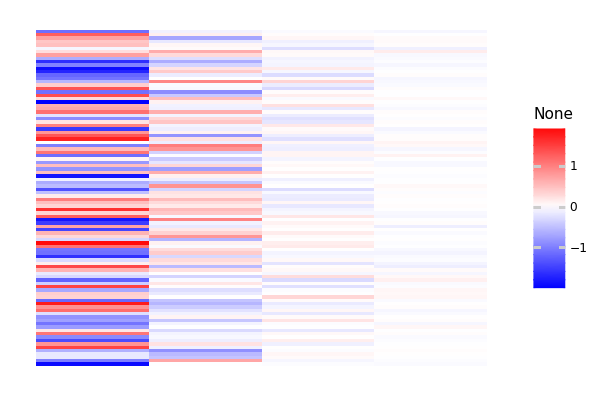

<ggplot: (8781343626707)>

In [49]:
lazytools.matrix_heatmap(latent_values, pole = 0)

In [50]:
actual_latent = np.matmul(art.data, art_pca.components_.T)

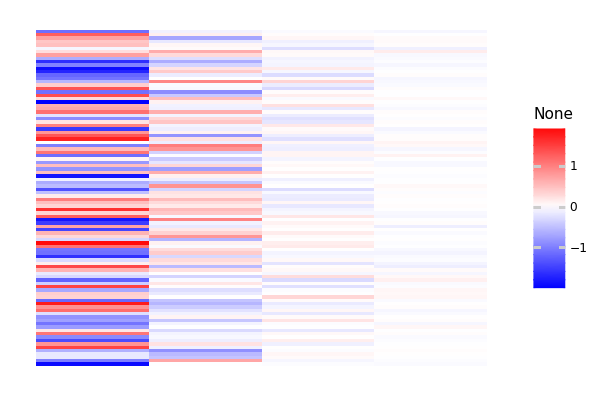

<ggplot: (8781342127855)>

In [51]:
lazytools.matrix_heatmap(actual_latent, pole = 0)

We have thus succeeded in fitting a simple LPC model to some artificial data. Unfortunately, my graphics card does not support GPU computing. Then, we will generate a specialized interface for 2-dimensional LPC, since that will often be our concern. Later, this fucntion will be re-integrated in the generalized interface. This means that we will first generate a estimate_state function, then discuss estimate_weights and generate that function, and finally combine the two.

### Creating first layer of abstraction

In [1]:
import predicode as pc

Using TensorFlow backend.


In [2]:
art = pc.DecayingMultiNormal(dimensions=10, samples = 100)
hpc = pc.MinimalHierarchicalModel(art.data, latent_dimensions = 4)

W0823 04:01:34.746461 140419061159744 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpm4zftp6v


In [3]:
hpc.train()

W0823 04:01:34.784617 140419061159744 deprecation.py:323] From /home/sflippl/.local/lib/python3.7/site-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0823 04:01:34.813914 140419061159744 deprecation_wrapper.py:119] From /home/sflippl/.local/lib/python3.7/site-packages/predicode/hierarchical/interfaces/minimal_model.py:24: The name tf.feature_column.input_layer is deprecated. Please use tf.compat.v1.feature_column.input_layer instead.

W0823 04:01:34.815494 140419061159744 deprecation.py:323] From /home/sflippl/.local/lib/python3.7/site-packages/tensorflow/python/feature_column/feature_column.py:205: NumericColumn._get_dense_tensor (from tensorflow.python.feature_column.feature_column_v2) is deprecated and w

In [4]:
hpc.evaluate()

W0823 04:01:41.933584 140419061159744 deprecation.py:323] From /home/sflippl/.local/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


{'loss': 3.9767117e-05, 'global_step': 10000}

W0823 04:01:52.425830 140419061159744 estimator.py:1000] Input graph does not use tf.data.Dataset or contain a QueueRunner. That means predict yields forever. This is probably a mistake.


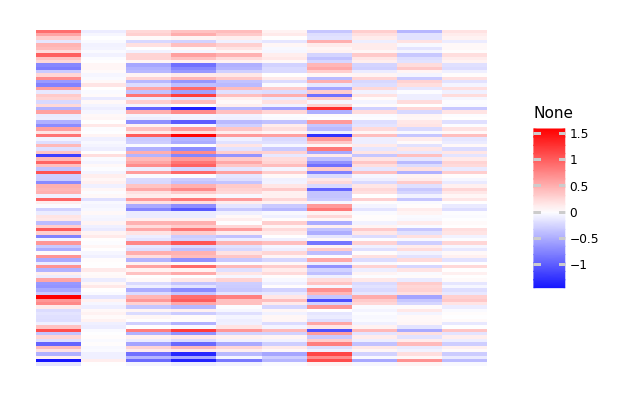

<ggplot: (8776140727146)>

In [6]:
import lazytools
lazytools.matrix_heatmap(hpc.predict(), pole = 0)

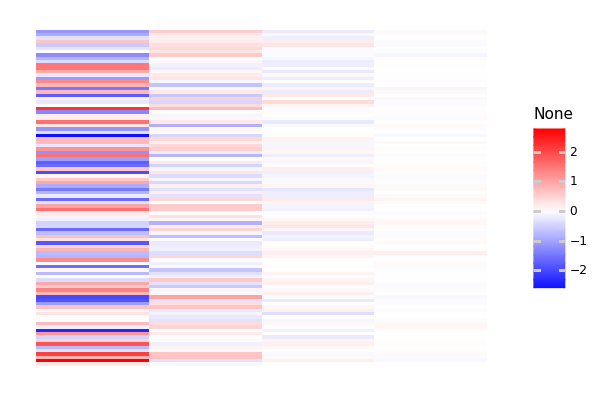

<ggplot: (-9223363260755593121)>

In [7]:
lazytools.matrix_heatmap(hpc.latent_values(), pole = 0)